# 付録
今回の分析に使用したPythonのコードを記述する。

# 目次
1. ディレクトリ構成
2. ライブラリのインストール
3. データの読み込みと前処理
4. 自然言語処理
    1. 形態素解析
    2. TF-IDFによる文章特徴量の生成
5. 主成分分析
6. 予測
    1. 重回帰分析
    2. ランダムフォレスト
    3. サポートベクター回帰
    4. LSTM
7. その他の分析

## 1. ディレクトリ構成
ファイルのディレクトリ構成は下記の通りになっている。

<pre>
./tfidf_lstm/
|- analysis.ipynb #このipynbファイル
|
|- data/
|  |- np_txt/
|  |  |- NP1998/
|  |  |   |- NP199801.txt #1998年01月の月例経済報告のテキストデータ
|  |  |   |- NP199802.txt #1998年02月の月例経済報告のテキストデータ
|  |  |   |- ...
|  |  |   |- NP199812.txt #1998年12月の月例経済報告のテキストデータ
|  |  |
|  |  |- NP1999/
|  |  |- ...
|  |  |- NP2019/
|  | 
|  |- market_data/
|     |- nikkei.csv #日経平均株価の時系列データ
|
|- output/ #分析結果などを出力したディレクトリ
|     |- tfidf.csv #tfidfの結果を出力したCSVファイル
|     |- model.h5 #LSTMのモデルファイル
|
|- support_file/
   |- stopwords.txt #ストップワードとして扱う単語を収録したテキストデータ

</pre>

## 2. ライブラリのインストール

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import keras
import MeCab
import glob
import re
import os

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.models import load_model

#豆腐防止用のフォント指定
plt.rcParams["font.family"] = "IPAexGothic"

Using TensorFlow backend.


In [7]:
#使用しているライブラリのバージョンを確認。
'''
"Versions of used main library.
pandas: 0.25.3
numpy: 1.17.4
sklearn: 0.22
tensorflow: 2.0.0
keras: 2.3.1
'''

print("pandas:",pd.__version__)
print("numpy:",np.__version__)
print("sklearn:",sklearn.__version__)
print("tensorflow:",tf.__version__)
print("keras:",keras.__version__)

pandas: 0.25.3
numpy: 1.17.4
sklearn: 0.22
tensorflow: 2.0.0
keras: 2.3.1


## 3. 分析に必要なデータの読み込みと前処理

In [8]:
#パスの指定
NP_TEXT_PATH = "./data/np_txt/"
STOPWORDS_PATH = "./support_file/stopwords.txt"
MARKET_DATA_PATH = "./data/market_data/"

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1990-02-01 to 2020-01-01
Data columns (total 6 columns):
close           360 non-null float64
open            360 non-null float64
high            360 non-null float64
low             360 non-null float64
volume          360 non-null object
before_ratio    360 non-null object
dtypes: float64(4), object(2)
memory usage: 29.7+ KB
None
              close     open     high      low volume before_ratio
date                                                              
1990-02-01  34592.0  37242.0  37887.0  32443.0      -       -6.98%
1990-03-01  29980.0  34587.0  34588.0  28830.0      -      -13.33%
1990-04-01  29585.0  29980.0  30524.0  27251.0      -       -1.32%
1990-05-01  33131.0  29594.0  33228.0  29519.0      -       11.99%
1990-06-01  31940.0  33110.0  33345.0  31086.0      -       -3.59%


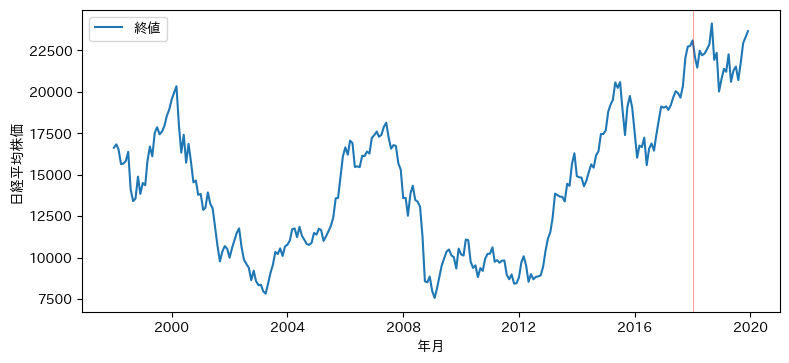

In [9]:
#日経平均株価
nikkei = pd.read_csv(MARKET_DATA_PATH + "nikkei.csv")

nikkei.columns = ["date", "close", "open", "high", "low", "volume", "before_ratio"]
nikkei["date"] = pd.to_datetime(nikkei["date"], format="%Y年%m月")
nikkei.set_index("date", inplace=True)

#終値
close = nikkei["close"].loc["1998":"2019"]

plt.figure(figsize=(9,4), dpi=100)
plt.plot(close)
plt.axvline("2018", c="red", alpha=0.4, linewidth=0.7)
plt.xlabel("年月")
plt.ylabel("日経平均株価")
plt.legend(["終値"])

print(nikkei.info())
print(nikkei.head())

In [10]:
#ストップワード
with open(STOPWORDS_PATH) as f:
    stop_words = f.read().split("\n")
    
print("例：",stop_words[0:5])

例： ['あそこ', 'あたり', 'あちら', 'あっち', 'あと']


## 4. 自然言語処理

### A. 形態素解析

In [11]:
#前処理用関数を定義
def preprocessing(text):
    
    """
    テキストから不要な記号や数字を取り除く。
    
    Parameters
    ----------
    text : str
        処理対象の文章。
        
    Returns
    -------
    text : str
        不要な記号や数字が取り除かれた文章。
    """
    
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+)', '' , text)
    text = re.sub(r'[【】]', '', text) 
    text = re.sub(r'[→]', '', text) 
    text = re.sub(r'[!-~]', '',text)
    text = re.sub(r'[︰-＠]', '', text)
    text = re.sub(' ', '', text)
    text = re.sub(r'\n+', '\n', text) 
    text = re.sub(r'[()]', '', text)
    text = text.replace(' ', '')
    return text

In [12]:
tagger = MeCab.Tagger('-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

def create_corpus(text):
    
    """
    テキストを形態素解析し、スペースを挟んだ単語のリストに変換する。
    
    Parameters
    ----------
    text : str
        処理対象の文章。
        
    Returns
    -------
    corpus : list of str
        単語が' 'を間に挟んだ文章に変換されたリスト
    """
    
    sentence = []
    
    word_info_list = tagger.parse(text).split("\n")
    
    for word_info in word_info_list[:-2]:
        word_info = word_info.split("\t")
        word = word_info[0] #単語
        #yomi = word_info[1] #読み仮名
        original = word_info[2] #原型
        word_class = word_info[3].split("-")[0] #品詞
    
        if original not in stop_words and word_class in ["名詞"]:
            sentence.append(original)
            
    corpus = " ".join(sentence)
    
    return corpus

In [13]:
#パスを指定し、ファイル一覧を取得する。
np_txt_path_list =  sorted(glob.glob(NP_TEXT_PATH + "*/*.txt"))

#テキストを格納する辞書を作成する。
text_dict = {}
text_list = []
year_month_list = []

for np_txt_path in np_txt_path_list[0:]:
    
    #パスから6桁の数値を取得する。(年月)
    year_month = re.findall(r'[0-9]{6}', np_txt_path)[0]
    year_month_list.append(year_month)
    upper = year_month[0:4]
    lower = year_month[4:]

    #テキストの読み込み
    f = open(np_txt_path)
    text = f.read()

    if upper not in text_dict:
        text_dict[upper] = {}
    
    text = preprocessing(text)
    text_list.append(create_corpus(text))
    
    text_dict[upper][lower] = text 

### B. TF-IDFによる文章特徴量の生成

In [37]:
count_vectorizer = CountVectorizer()
word_corpus = count_vectorizer.fit_transform(text_list)

ttf = TfidfTransformer(norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=False)
tfidf = ttf.fit_transform(word_corpus)

#tfidf
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=count_vectorizer.get_feature_names(), index=year_month_list)
tfidf_df.index = pd.to_datetime(tfidf_df.index, format='%Y%m')

#tf
tf_df = pd.DataFrame(word_corpus.toarray(), columns=count_vectorizer.get_feature_names(), index=year_month_list)
tf_df.index = pd.to_datetime(tfidf_df.index, format='%Y%m')

#idf
idf_df = pd.Series(ttf.idf_,index=count_vectorizer.get_feature_names())

#保存
tfidf_df.to_csv("./output/tfidf_result.csv")

tfidf_df.head()

## 5. 主成分分析

In [15]:
#主成分分析
pca = PCA(n_components=30)
feature = pca.fit_transform(tfidf_df)
feature_df = pd.DataFrame(index=tfidf_df.index, columns=["comp_"+str(n) for n in range(1, pca.n_components_+1)], data=feature)
feature_df.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_21,comp_22,comp_23,comp_24,comp_25,comp_26,comp_27,comp_28,comp_29,comp_30
1998-01-01,0.483871,0.165456,0.340079,-0.041505,0.039839,0.035262,-0.034898,-0.003148,0.034843,0.001278,...,0.051753,0.141288,0.002112,0.032236,-0.019412,-0.014789,-0.050819,-0.036265,0.028018,-0.086829
1998-02-01,0.511601,0.172842,0.347299,-0.035786,0.048709,0.048607,-0.034105,-0.008191,0.023613,-0.003773,...,0.056301,0.000704,0.027042,0.054235,-0.070977,0.043570,-0.111067,0.012374,0.023477,-0.099144
1998-03-01,0.506006,0.159186,0.341385,-0.045808,0.052620,0.055279,-0.049076,0.003431,0.043197,-0.007973,...,0.062745,0.005909,0.058099,0.025373,-0.057970,0.043283,-0.104294,0.015611,0.056923,-0.081434
1998-04-01,0.489269,0.178370,0.335758,-0.038796,0.066065,0.029242,-0.042652,-0.004492,0.014932,-0.004970,...,0.059548,0.082294,0.058764,0.039486,0.013293,-0.038229,-0.033531,-0.043552,0.080746,-0.086936
1998-05-01,0.500138,0.210174,0.335767,-0.033195,0.063101,0.024987,-0.046768,-0.007010,0.015858,-0.007939,...,0.058690,-0.048273,0.037357,0.042380,-0.063807,0.041587,-0.104795,0.031674,0.082011,-0.102141


Cumulative contribution: 0.7565198049783376
over 0.75 index number: 12


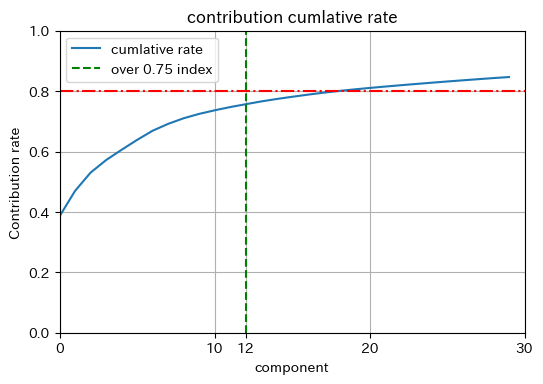

In [16]:
#累積寄与率の可視化
cumsum = 0
for num ,explained_variance_ratio in enumerate(pca.explained_variance_ratio_):
    cumsum += explained_variance_ratio
    if cumsum >= 0.75:
        print("Cumulative contribution:",cumsum)
        print("over 0.75 index number:",num)
        break
        
plt.figure(figsize=(6,4),dpi=100)
plt.plot(pca.explained_variance_ratio_.cumsum())

plt.axvline(num, linestyle="--",color="green")
plt.axhline(0.8, linestyle="-.", color="red")
plt.xticks(np.arange(0, 280 + 1, 10), rotation=0)
plt.xlim(0,pca.n_components)
plt.ylim(0,1)

plt.title("contribution cumlative rate")
plt.ylabel("Contribution rate")
plt.xlabel("component")
plt.grid(True)
plt.xticks([0, 10, num, 20, 30])

plt.legend(["cumlative rate", "over 0.75 index"])
plt.show()

## 6. 予測 

In [17]:
#データセット作成用の関数を定義
def create_dataset(data, feature_columns, target_columns, train_data_length):
    
    """
    scikit-learnに対応したデータセットに変換する。

    Parameters
    ----------
    data : pandas.DataFrame
        変換対象のデータフレーム
    feature_columns : list of str
        予測・分類のために使用したい特徴量の列名
    target_columns : str
        予測・分類したい対象の列名
    train_data_length : int
        訓練データとして使用するデータの長さ
    
    Returns
    -------
    X_train : list
        訓練データの特徴量
    y_train : list
        訓練データの予測・分類対象
    X_test : list
        テストデータの特徴量
    y_test : list
        テストデータの予測・分類対象
    """
    
    X_train = data[feature_columns].iloc[0:train_data_length].values
    X_test = data[feature_columns].iloc[train_data_length:].values
    y_train = data[target_columns].iloc[0:train_data_length].values
    y_test = data[target_columns].iloc[train_data_length:].values
    
    return X_train, y_train, X_test, y_test

In [18]:
#mergeするDataFrameはtfidf_df or feature_dfを選択する。
merge_df = feature_df.iloc[:,0:num].join(close)

minmax = MinMaxScaler(feature_range=(0,1))
merge_df[:] = minmax.fit_transform(merge_df)

#今回は訓練データの長さを200、テストデータの長さを残りの64にした。
X_train, y_train, X_test, y_test = create_dataset(merge_df, 
                                                  merge_df.columns[:-1], 
                                                  merge_df.columns[-1], 
                                                  train_data_length=240)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(240, 12)
(24, 12)
(240,)
(24,)


### A. 重回帰分析

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("mae:",mean_absolute_error(y_test, lr_pred))
print("mse:",mean_squared_error(y_test, lr_pred))

mae: 0.47588561643403987
mse: 0.2782496222294994


### B. サポートベクター回帰

In [20]:
svr = SVR(C=900, epsilon=0.007,kernel='rbf', gamma='auto')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

print("mae:",mean_absolute_error(y_test, svr_pred))
print("mse:",mean_squared_error(y_test, svr_pred))

mae: 0.14867139746898902
mse: 0.031754401298131


### C. ランダムフォレスト

In [21]:
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=0, criterion="mse")
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("mae:",mean_absolute_error(y_test, rf_pred))
print("mse:",mean_squared_error(y_test, rf_pred))

mae: 0.20354631828538416
mse: 0.060174646005221245


### D. LSTM

In [22]:
#データ整形用の関数
def prepare_data_for_lstm(df, feature_columns, target_column, train_data_length, window_size, normalized=False):
    
    """
    kerasに対応したデータセットに変換する。

    Parameters
    ----------
    df : pandas.DataFrame
        変換対象のデータフレーム
    feature_columns : list of str
        予測・分類のために使用したい特徴量の列名
    target_columns : str
        予測・分類したい対象の列名
    train_data_length : int
        訓練データとして使用するデータの長さ
    window_size : int
        時間窓の長さ
    normalized : bool
        Falseである場合、正規化を行う。Trueである場合行わない。
    
    Returns
    -------
    X_train : list
        訓練データの特徴量
    y_train : list
        訓練データの予測・分類対象
    X_test : list
        テストデータの特徴量
    y_test : list
        テストデータの予測・分類対象
    """
    
    print("feature:",feature_columns)
    print("target:", target_column)
    
    feature_columns.append(target_column)
    columns = feature_columns
    values = df[columns].values
    
    if normalized == False:
        sc = MinMaxScaler()
        values = sc.fit_transform(values)
        
    #create dataset
    dataset = []
    for t in range(0, len(df) - window_size):
        dataset.append(values[t:t+window_size])
    dataset = np.asarray(dataset)
    print("shape of dataset:",dataset.shape)
    
    #split data 
    X_train = dataset[0:train_data_length, :, :-1] 
    y_train = dataset[0:train_data_length, 0, -1]
    X_test = dataset[train_data_length:,: ,:-1]
    y_test = dataset[train_data_length:, 0, -1]
    
    return X_train, y_train, X_test, y_test

In [23]:
window = 60
train_size = 180 #len(merge_df) - window - 12
target_name = "close"

print(train_size)

merge_df = feature_df.iloc[:, 0:12].join(close)

X_train, y_train, X_test, y_test = prepare_data_for_lstm(merge_df,
                                                         feature_columns=merge_df.columns[:-1].tolist(),
                                                         target_column=target_name,
                                                         train_data_length=train_size,
                                                         window_size=window,
                                                         normalized=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

180
feature: ['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 'comp_7', 'comp_8', 'comp_9', 'comp_10', 'comp_11', 'comp_12']
target: close
shape of dataset: (204, 60, 13)
(180, 60, 12)
(24, 60, 12)
(180,)
(24,)


In [25]:
#モデルを読み込む場合(推奨)
model = keras.models.load_model('./output//model.h5', compile=False)

In [24]:
#モデル構築(予め出力しているモデルのデータがあるので、そちらの読み込みを推奨)

#乱数の固定
np.random.seed(1)
tf.random.set_seed(1)

#LSTMのモデル構築。
#今回はLSTM層と全結合層を一つずつ使うモデルを構築した。
model = Sequential() 
model.add(LSTM(units=1024,
               input_shape=(window, len(merge_df.columns)-1), 
               return_sequences=False, 
               ))
model.add(Dense(units=1, 
                activation="linear"))

#最適化アルゴリズムにRMSpropを使用。
#学習率は過学習防止のため1e-5にしている。
optimizer = RMSprop(learning_rate=1e-5) 
model.compile(loss="mse", optimizer=optimizer)

#学習
model.fit(x=X_train, y=y_train, batch_size=1, epochs=1000, verbose=2, validation_split=0.25,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto')])

print("complete!")

KeyboardInterrupt: 

In [ ]:
#モデルの保存
#model.save('/users/kengo/model.h5', include_optimizer=False)

In [26]:
#LSTMの精度の計算
print("mae", mean_absolute_error(y_test, model.predict(X_test).ravel()))
print("mse", mean_squared_error(y_test, model.predict(X_test).ravel()))

mae 0.052886290100664
mse 0.004788323753717554


In [27]:
#決定係数
r2_score(y_test, model.predict(X_test).ravel())

0.46580287192947

## 7. その他の分析

In [28]:
#各主成分における寄与率を計算する。
comp_df = pd.DataFrame(pca.components_.T, columns=["主成分" + str(n) for n in range(1,pca.n_components_+1)], index=tfidf_df.columns)

factor_loading = pd.DataFrame(index=range(1,11))
for col_name, item in comp_df.iteritems():
    factor_loading[col_name] = abs(item).sort_values(ascending=False)[0:10].index
    
factor_loading.iloc[:, 0:30].head(10)

,主成分1,主成分2,主成分3,主成分4,主成分5,主成分6,主成分7,主成分8,主成分9,主成分10,...,主成分21,主成分22,主成分23,主成分24,主成分25,主成分26,主成分27,主成分28,主成分29,主成分30
1,同月,減少,イギリス,消費税率,動き,持ち直している,持ち直している,改善,推移,持ち直し,...,緩やか,上方修正,プラス,上昇,増加,持ち直し,横ばい,東北地方,急速,都合
2,前年,増加,季節調整,駆け込み需要,上昇,横ばい,深刻,通商問題,東日本大震災,通商問題,...,動き,減少,寄与,推移,東北地方,プラス,制度,太平洋沖地震,兆し,勤め先
3,緩やか,改善,減少,引上げ,持ち直し,増加,横ばい,動き,急速,東日本大震災,...,足踏み,上旬,直接,足踏み,太平洋沖地震,寄与,太平洋沖地震,一部,直接,兆し
4,横ばい,大幅,悪化,反動,東日本大震災,減少,東日本大震災,緩やか,大幅,足踏み,...,深刻,月央,推移,平成,急速,太平洋沖地震,東北地方,東日本大震災,金融危機,拡大
5,先行き,横ばい,平均,持ち直し,テンポ,平成,持ち直し,東日本大震災,金融危機,中国経済,...,横ばい,テンポ,マイナス,増加,下落,東北地方,通商問題,上旬,大幅,状態
6,季節調整値,回復,同月,直接,減少,景気刺激策,景気刺激策,横ばい,横ばい,足踏み状態,...,下落,年度,最終,上向き,上昇,最終,増加,直接,一部,着実
7,景気,緩やか,相場,緩やか,平成,深刻,必要,持ち直し,持ち直している,当面,...,東北地方,企業短期経済観測調査,急速,反動,洪水,民間,持ち直し,弱り目,横ばい,失業者
8,持ち直し,悪化,フランス,回復,成年,引上げ,足踏み状態,回復,影響,兆し,...,太平洋沖地震,減益,持ち直し,横ばい,一部,消費支出,東日本大震災,月央,駆け込み需要,中心
9,季節調整,深刻,深刻,持ち直している,下落,消費税率,効果,影響,悪循環,復興,...,急速,上期,兆し,下げ,成年,増加,直接,立て直し,後退,水準
10,動き,急速,平成,効果,悪化,駆け込み需要,成年,兆し,持ち直し,2019年,...,減少,深刻,民間,東北地方,改善,通商問題,緊張,下げ止まり,増加傾向,低下


In [29]:
#それぞれの因子負荷量のランキングを表示する。
factor_loading.iloc[:, 0:10].head(10)

,主成分1,主成分2,主成分3,主成分4,主成分5,主成分6,主成分7,主成分8,主成分9,主成分10
1,同月,減少,イギリス,消費税率,動き,持ち直している,持ち直している,改善,推移,持ち直し
2,前年,増加,季節調整,駆け込み需要,上昇,横ばい,深刻,通商問題,東日本大震災,通商問題
3,緩やか,改善,減少,引上げ,持ち直し,増加,横ばい,動き,急速,東日本大震災
4,横ばい,大幅,悪化,反動,東日本大震災,減少,東日本大震災,緩やか,大幅,足踏み
5,先行き,横ばい,平均,持ち直し,テンポ,平成,持ち直し,東日本大震災,金融危機,中国経済
6,季節調整値,回復,同月,直接,減少,景気刺激策,景気刺激策,横ばい,横ばい,足踏み状態
7,景気,緩やか,相場,緩やか,平成,深刻,必要,持ち直し,持ち直している,当面
8,持ち直し,悪化,フランス,回復,成年,引上げ,足踏み状態,回復,影響,兆し
9,季節調整,深刻,深刻,持ち直している,下落,消費税率,効果,影響,悪循環,復興
10,動き,急速,平成,効果,悪化,駆け込み需要,成年,兆し,持ち直し,2019年


In [30]:
factor_loading.iloc[:, 10:20].head(10)

,主成分11,主成分12,主成分13,主成分14,主成分15,主成分16,主成分17,主成分18,主成分19,主成分20
1,持ち直している,増加,増加,持ち直し,下げ止まり,成年,緩やか,緩やか,成年,年度
2,増加,成年,持ち直している,下落,兆し,緩やか,下げ止まり,横ばい,緩やか,テンポ
3,横ばい,持ち直している,平成,足踏み,増加,横ばい,成年,持ち直している,含み,上昇
4,景気刺激策,足踏み,募集,増加,東日本大震災,下落,弱り目,足踏み,大幅,減益
5,改善,動き,受付期間,回復,緩やか,東日本大震災,平成,減少,持ち直している,上旬
6,革命,募集,下げ止まり,下げ止まり,傾向,年月,動き,回復,急速,兆し
7,慎重,受付期間,増益,減速,下落,平成,深刻,持ち直し,下げ,月央
8,上昇,全店,最終需要,減益,デフレ脱却,生産活動,兆し,東日本大震災,景気,持ち直し
9,弱り目,下げ止まり,横ばい,動き,成年,増益,傾向,弱り目,部門,足踏み
10,信用収縮,通商問題,動き,大幅,持ち直している,足踏み,東北地方,推移,マインド,上方修正


In [31]:
factor_loading.iloc[:, 20:30].head(10)

,主成分21,主成分22,主成分23,主成分24,主成分25,主成分26,主成分27,主成分28,主成分29,主成分30
1,緩やか,上方修正,プラス,上昇,増加,持ち直し,横ばい,東北地方,急速,都合
2,動き,減少,寄与,推移,東北地方,プラス,制度,太平洋沖地震,兆し,勤め先
3,足踏み,上旬,直接,足踏み,太平洋沖地震,寄与,太平洋沖地震,一部,直接,兆し
4,深刻,月央,推移,平成,急速,太平洋沖地震,東北地方,東日本大震災,金融危機,拡大
5,横ばい,テンポ,マイナス,増加,下落,東北地方,通商問題,上旬,大幅,状態
6,下落,年度,最終,上向き,上昇,最終,増加,直接,一部,着実
7,東北地方,企業短期経済観測調査,急速,反動,洪水,民間,持ち直し,弱り目,横ばい,失業者
8,太平洋沖地震,減益,持ち直し,横ばい,一部,消費支出,東日本大震災,月央,駆け込み需要,中心
9,急速,上期,兆し,下げ,成年,増加,直接,立て直し,後退,水準
10,減少,深刻,民間,東北地方,改善,通商問題,緊張,下げ止まり,増加傾向,低下


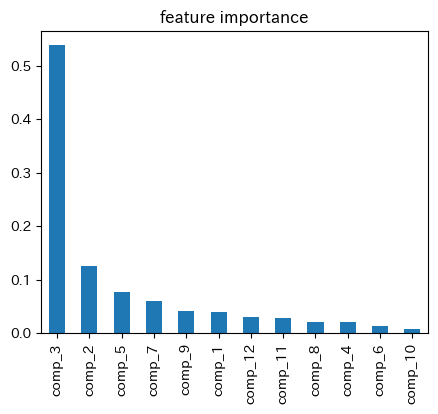

In [32]:
#特徴重要度の可視化
plt.figure(figsize=(5,4),dpi=100)
rf_feature_importance = pd.Series(rf.feature_importances_, index=feature_df.iloc[:,0:rf.n_features_].columns)
rf_feature_importance.sort_values(ascending=False).plot(kind="bar", title="feature importance")

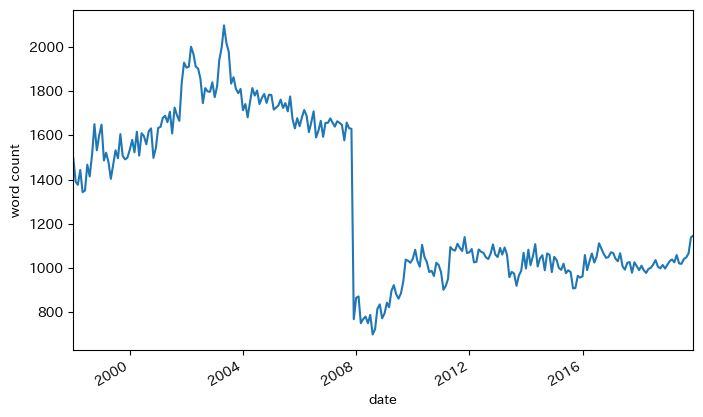

In [33]:
#総単語数の可視化
plt.figure(figsize=(8,5), dpi=100)
tf_df.sum(axis=1).plot()
plt.xlabel("date")
plt.ylabel("word count")
plt.show()

In [34]:
#重回帰分析の回帰係数
print("intercept:",lr.intercept_)
print(pd.Series(lr.coef_, index=merge_df.columns[:-1], name="linear_coef"))

intercept: 0.5374081974640473
comp_1    -0.029294
comp_2    -0.420779
comp_3     0.472547
comp_4    -0.043898
comp_5     0.321410
comp_6     0.053841
comp_7     0.026456
comp_8    -0.485444
comp_9    -0.031669
comp_10   -0.310657
comp_11    0.155288
comp_12   -0.311336
Name: linear_coef, dtype: float64
